In [1]:
import pickle
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import numpy as np
import pandas as pd

In [2]:
result_dir = '/bsuscratch/zacharykeskinen/data/infrasound/wind_results'
fig_dir = '/bsuhome/zacharykeskinen/infrasound/figures'
tmp_dir = join(result_dir,'tmp')
super_x = []
for f in glob(join(tmp_dir, '*')):
    with open(f, 'rb') as f:
        df = pickle.load(f)
    super_x.append(df)
res = pd.concat(super_x)
res['wind_cat'] = pd.cut(res['wind'], bins = [-0.1,3,5,11], labels = ['low-wind','med-wind','high-wind'])
with open(join(result_dir, 'windv2.pkl'), 'wb') as f:
    pickle.dump(res, f)


In [3]:
result_dir = '/bsuscratch/zacharykeskinen/data/infrasound/wind_results'
with open(join(result_dir, 'windv3.pkl'), 'rb') as f:
    wind = pickle.load(f)
wind['wind_cat'] = pd.cut(wind['wind'], bins = [-0.1,3,5,11], labels = ['Low Wind (0-3 m/s)','Med Wind (3-5 m/s)','High Wind (5+ m/s)'])

In [4]:
wind[['fs','powers']] = pd.DataFrame(wind['power'].tolist(), index=wind.index)
# wind = wind.loc[wind.cor < wind.cor.quantile(0.8)]
# wind = wind.loc[wind.wind > 6]
# wind = wind.drop(['power'], axis = 1)
powers = pd.DataFrame(wind['powers'].tolist(), index=wind.index, columns = wind.iloc[0]['fs'])
powers[['sd_delta','cor','wind']] = wind[['sd_delta','cor','wind']]
#powers.loc[powers.sd_delta < -0.5, 'sd_delta'] = -0.5
plot = powers.drop(['cor','wind'], axis= 1).groupby('sd_delta').mean()
new_index = np.linspace(plot.index[0], plot.index[-1], len(plot))
df_resampled = plot.reindex(plot.index.union(new_index)).interpolate(method='nearest').loc[new_index]

In [5]:
levels = [[None,0],[0,0.2],[0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1],[1,1.2],[1.2,None]]
plot = pd.DataFrame()
for low, high in levels:
    d = {}
    if low == None:
        sub = powers.loc[powers.sd_delta < high]
        low = -0.2
    elif high == None:
        sub = powers.loc[powers.sd_delta > low]
    else:
        sub = powers.loc[(powers.sd_delta > low) & (powers.sd_delta < high)]
    sub = sub.drop(['sd_delta', 'cor', 'wind'], axis = 1).dropna().mean()
    sub.index = np.round(sub.index.astype(float),2)
    d[low] = sub
    plot = pd.concat([plot, pd.DataFrame.from_dict(d)], axis = 1)

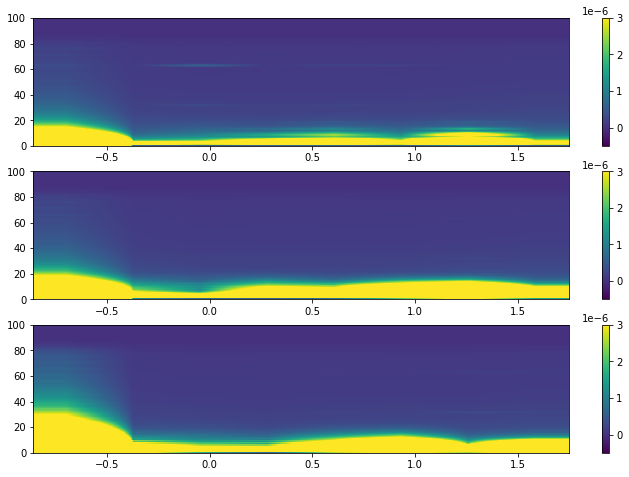

In [6]:
from re import A


f, axes = plt.subplots(3, figsize= (12,8))
levels = [[None,0],[0,0.2],[0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1],[1,1.2],[1.2,None]]

for i, (low, high) in enumerate([[0,3],[3,5],[5,10]]):
    ax = axes[i]
    power_sub = powers.loc[(powers.wind < high) & (powers.wind > low)]
    plot = pd.DataFrame()
    for low, high in levels:
        d = {}
        if low == None:
            sub = power_sub.loc[power_sub.sd_delta < high]
            low = -0.2
        elif high == None:
            sub = power_sub.loc[power_sub.sd_delta > low]
        else:
            sub = power_sub.loc[(power_sub.sd_delta > low) & (power_sub.sd_delta < high)]
        sub = sub.drop(['sd_delta', 'cor', 'wind'], axis = 1).dropna().mean()
        sub.index = np.round(sub.index.astype(float),2)
        d[low] = sub
        plot = pd.concat([plot, pd.DataFrame.from_dict(d)], axis = 1)
    im = ax.imshow(plot[::-1], aspect = 'auto',vmin=-0.0000005, vmax=0.000003, interpolation = 'bilinear',extent = (df_resampled.index[0], df_resampled.index[-1], df_resampled.columns[0], df_resampled.columns[-1]))
    plt.colorbar(im, ax= ax)

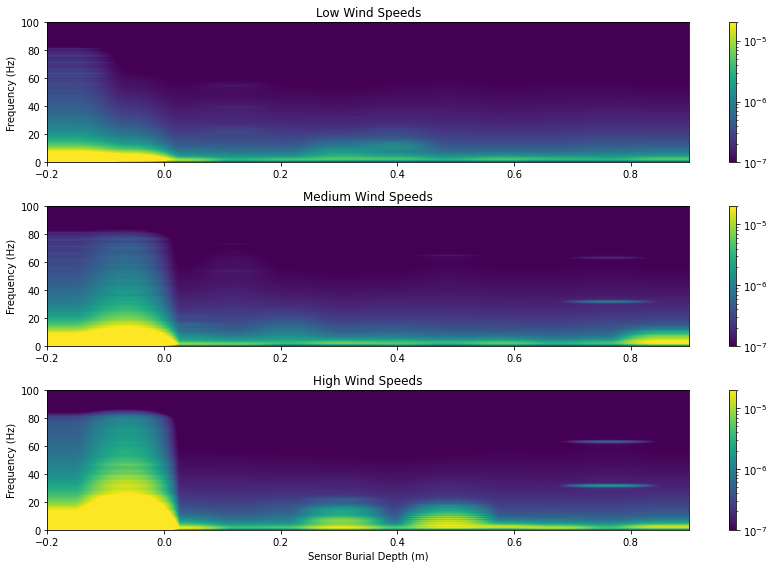

In [7]:
from matplotlib.colors import LogNorm
f, axes = plt.subplots(3, figsize= (12,8))
norm=LogNorm(vmin=1e-7, vmax=2e-5)
title_dic = {'0-3':'Low Wind Speeds', '3-5':'Medium Wind Speeds', '5-10':'High Wind Speeds'}
for i, (low, high) in enumerate([[0,3],[3,5],[5,10]]):
    ax = axes[i]
    with open(join(result_dir, 'windv2.pkl'), 'rb') as f:
        wind = pickle.load(f)
    wind[['fs','powers']] = pd.DataFrame(wind['power'].tolist(), index=wind.index)
    # wind = wind.loc[wind.cor < wind.cor.quantile(0.5)]
    wind.loc[wind.sd_delta < -0.2, 'sd_delta'] = -0.2
    powers = pd.DataFrame(wind['powers'].tolist(), index=wind.index, columns = wind.iloc[0]['fs'])
    powers[['sd_delta','cor','wind']] = wind[['sd_delta','cor','wind']]

    plot = powers.loc[(powers.wind < high) & (powers.wind > low)].drop(['cor','wind'], axis= 1).groupby('sd_delta').mean()
    new_index = np.linspace(plot.index[0], plot.index[-1], len(plot))
    #df_resampled = plot.reindex(plot.index.union(new_index)).interpolate(method='nearest').loc[new_index]
    df_resampled = plot.reindex(np.arange(-0.2, 1, 0.1), method = 'nearest')
    extent = (df_resampled.index[0], df_resampled.index[-1], df_resampled.columns[0], df_resampled.columns[-1])
    # extent = (-0.2,1,0,100)
    im = ax.imshow(df_resampled.T.iloc[::-1],extent = extent, aspect = 'auto', norm = norm, interpolation = None)
    ax.set_ylabel('Frequency (Hz)')
    title = title_dic[f'{low}-{high}']
    # ax.set_title(f'Wind Speeds from {low} to {high} m/s')
    ax.set_title(title)
    plt.colorbar(im, ax = ax)
axes[2].set_xlabel('Sensor Burial Depth (m)')
#plt.xlim(-0.2,0.5)
plt.tight_layout()

## scatter plots

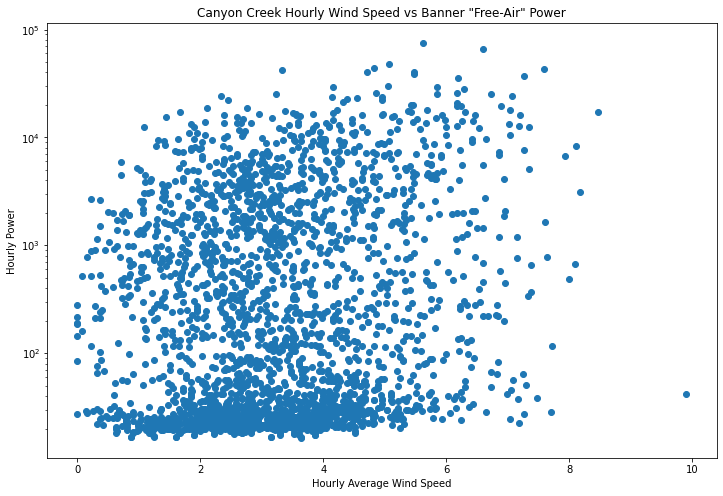

In [8]:
plt.subplots(figsize = (12,8))
plt.scatter(wind[(wind.sd_delta < -0.1) & (wind.cor > 0)].wind, wind[(wind.sd_delta < -0.1) & (wind.cor > 0)].broad_power)
plt.yscale('log')
plt.ylabel('Hourly Power')
plt.xlabel('Hourly Average Wind Speed')
plt.title('Canyon Creek Hourly Wind Speed vs Banner "Free-Air" Power')
plt.savefig(join(fig_dir, 'wind','free-air-canyon-scatter.png'))

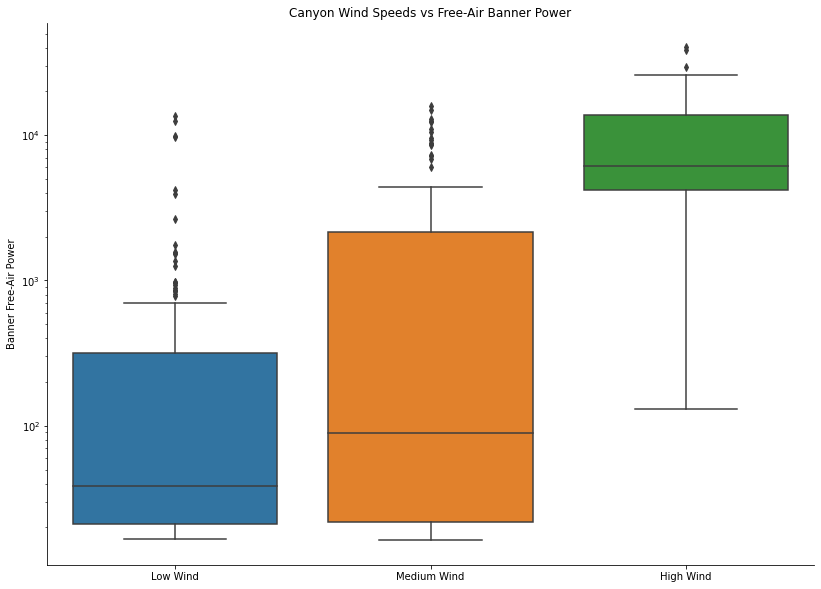

In [9]:

sns.catplot(data = wind[(wind.h != 2) & (wind.sd_delta < -0.1)], x = 'wind_cat', y = 'broad_power', kind = 'box', height=8.27, aspect=11.7/8.27)
plt.yscale('log')
plt.ylabel('Banner Free-Air Power')
plt.xlabel('')
plt.xticks(ticks = [0,1,2], labels = ['Low Wind','Medium Wind','High Wind'])
plt.title('Canyon Wind Speeds vs Free-Air Banner Power')
plt.savefig(join(fig_dir, 'wind','free-air-canyon-box.png'))

In [10]:
wind.wind_cat.unique()

['low-wind', 'med-wind', 'high-wind']
Categories (3, object): ['low-wind' < 'med-wind' < 'high-wind']

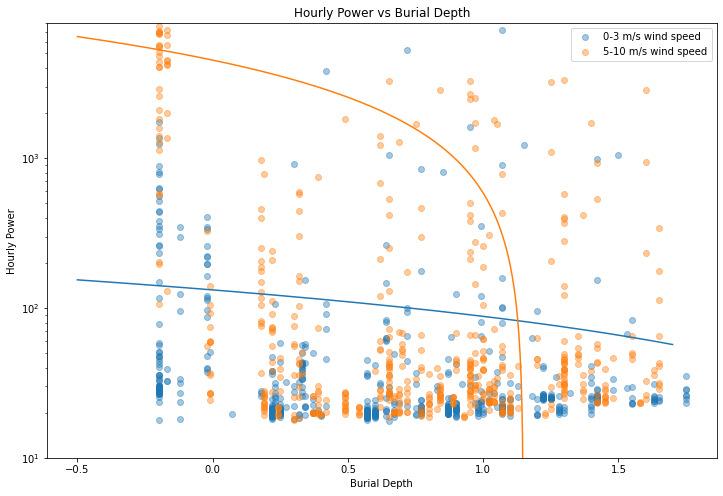

In [11]:
from sklearn.linear_model import LinearRegression
plt.subplots(figsize = (12,8))
for i, (low, high) in enumerate([[0,3],[5,10]]):
    # if i == 2:
        plot = wind.loc[(wind.wind < high) & (wind.wind > low) & (wind.cor > 0.2)]
        plt.scatter(plot.sd_delta, plot.broad_power, label = f'{low}-{high} m/s wind speed', alpha = 0.4)
        reg = LinearRegression().fit(plot.sd_delta.values.reshape(-1, 1), plot.broad_power.values.reshape(-1, 1))
        x = np.linspace(-0.5, 1.7, 1000)
        y = reg.predict(x.reshape(-1, 1))
        plt.plot(x,y)

plt.legend()
plt.yscale('log')
plt.ylim(10e0, 8e3)
plt.ylabel('Hourly Power')
plt.xlabel('Burial Depth')
plt.title('Hourly Power vs Burial Depth')
plt.savefig(join(fig_dir, 'wind','scatter_power_depth.png'))

In [12]:
sns.set(rc={
 'axes.axisbelow': True,
 'axes.edgecolor': 'grey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.grid.axis':'y',
 'axes.labelcolor': 'black',
 'axes.linewidth': 1,
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'lightgrey',
 'figure.figsize': (18, 12),
 'grid.color': 'grey',
 'grid.alpha':1,
 'grid.linewidth':0.5,
 'image.aspect':'auto',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'savefig.dpi':300,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'grey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'grey',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.color':'grey',
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":26,
                                "axes.labelsize":16})

## Paper Figure of Wind Speed

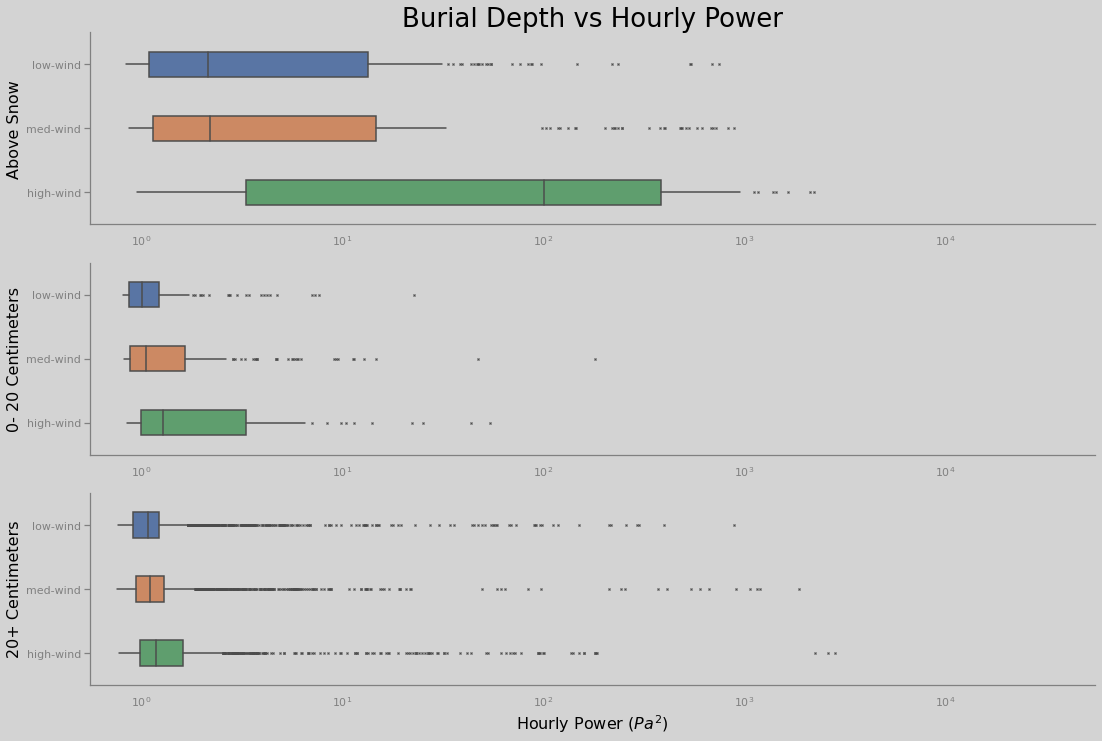

In [24]:
f, axes = plt.subplots(3)
wind_snow = wind.loc[(wind.h != 2.00) & (wind.cor < 1)].copy()
wind_snow.loc[:, 'broad_power'] = wind_snow.loc[:, 'broad_power']/(60*60/200)
ylabels = ['Above Snow','0- 20 Centimeters','20+ Centimeters']
for j, h in enumerate([0, (0, 0.2), 0.2]):
        if j == 0:
            plot = wind_snow.loc[(wind_snow.sd_delta < h)]
        if j == 1:
            ax = plot = wind_snow.loc[(wind_snow.sd_delta > h[0]) & (wind_snow.sd_delta < h[1])]
        if j == 2:
            plot = wind_snow.loc[(wind_snow.sd_delta > h)]
        
        # plot.loc[:,'broad_power'] = (plot['broad_power']/(60*60)).values
        ax = sns.boxplot(y = 'wind_cat', x = 'broad_power', data = plot, ax = axes[j], showcaps = False, flierprops={"marker": "x"}, fliersize= 2, width = 0.4)

        ax.set_ylabel(ylabels[j])
        if j == 0:
            ax.set_title('Burial Depth vs Hourly Power')
        if j == 2:
            ax.set_xlabel('Hourly Power ($Pa^{2}$)')
        else:
            ax.set_xlabel('')
            ax.set_xticks([])
        ax.set_xscale('log')
        ax.set_xlim(10/(60*60/200), 10e5/(60*60/200))
plt.savefig(join('/bsuhome/zacharykeskinen/infrasound/figures/wind','boxplot_wind_depth_binv4'), dpi = 300)

## P Test

In [14]:
from scipy.stats import ttest_ind
ttest_ind(wind.loc[wind.wind_cat == 'med-wind', 'broad_power'].values, wind.loc[wind.wind_cat == 'low-wind', 'broad_power'].values)

Ttest_indResult(statistic=5.296952570584035, pvalue=1.2011972531843947e-07)

In [15]:
from scipy.stats import normaltest
normaltest(wind.loc[wind.wind_cat == 'med-wind', 'broad_power'].values)

NormaltestResult(statistic=7005.506027736067, pvalue=0.0)

In [16]:
from scipy.stats import mannwhitneyu
mannwhitneyu(wind.loc[wind.wind_cat == 'med-wind', 'broad_power'].values, wind.loc[wind.wind_cat == 'low-wind', 'broad_power'].values)

MannwhitneyuResult(statistic=14925031.0, pvalue=1.9236815995329708e-13)

In [17]:
from scipy.stats import mannwhitneyu
mannwhitneyu(wind.loc[wind.wind_cat == 'med-wind', 'broad_power'].values, wind.loc[wind.wind_cat == 'high-wind', 'broad_power'].values)

MannwhitneyuResult(statistic=3538300.0, pvalue=4.371347364044847e-20)

## Scatter of air vs buried

In [18]:
d = pd.to_datetime('2001-02-01')
d = d.tz_localize('UTC')
t = [d + pd.Timedelta(f'{si} hours') for si in range(24)]
t_local = [t.tz_convert('America/Boise') for t in t]
# t_hour = [t.time() for t in t_local]
for i, d in enumerate(t_local):
    if d.day == 31:
        t_local[i] = t_local[i] + pd.Timedelta('1 day')

with open('/bsuhome/zacharykeskinen/infrasound/results/hourly_average/v1', 'rb') as f:
    hourly = pickle.load(f)

hour_power = pd.DataFrame(hourly, index= t_local, columns = [0.33,0.66,1,1.33,2.0])
hour_power = hour_power.sort_index()

In [19]:
canyon = pd.read_csv('/bsuscratch/zacharykeskinen/data/infrasound/snotel/canyon_wx.csv', comment = '#', parse_dates=['Date_Time'], index_col = ['Date_Time'])
units = canyon.iloc[0]
canyon = canyon.iloc[1:]
# convert all columns of DataFrame
canyon = canyon.apply(pd.to_numeric, errors = 'ignore')
canyon = canyon.loc[:pd.to_datetime('2022-05-15')]
canyon = canyon.tz_convert('UTC')

/tmp/ipykernel_24573/548296875.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  canyon = canyon.loc[:pd.to_datetime('2022-05-15')]


In [20]:
s = canyon.loc[(canyon.index > pd.to_datetime('2022-01-01T00:00:00 UTC')) & (canyon.index < pd.to_datetime('2022-04-01T00:00:00 UTC')), 'wind_speed_set_1']

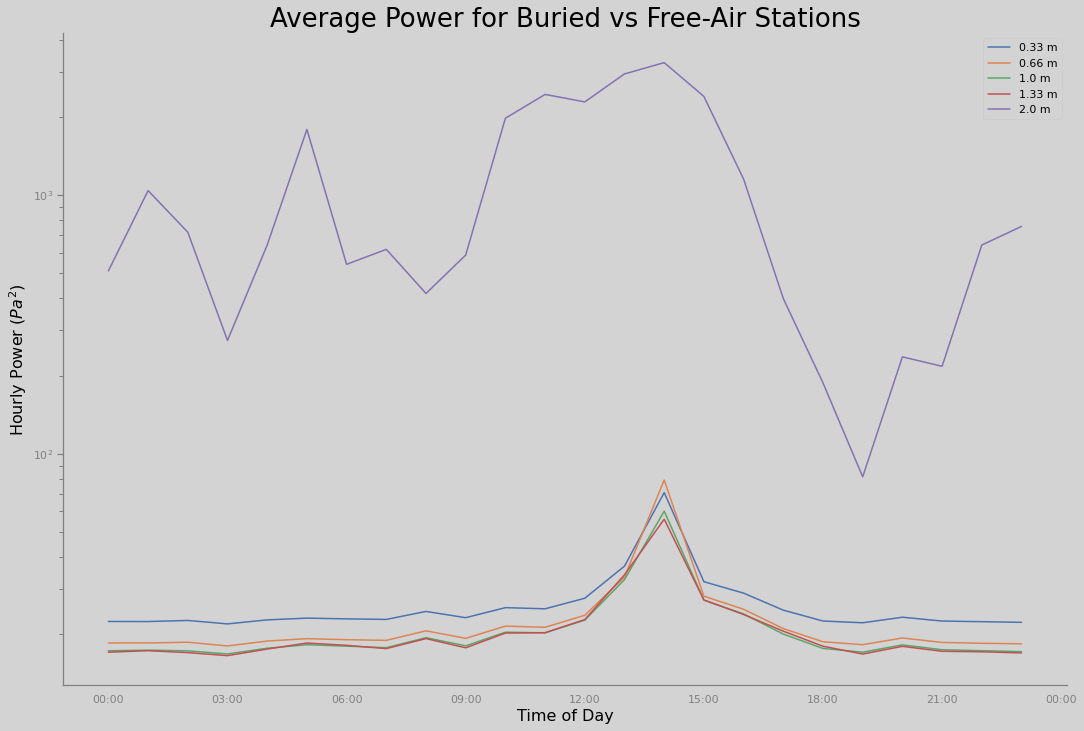

In [21]:
import matplotlib.dates as mdates
from dateutil import tz
fig, ax = plt.subplots()
for col in hour_power.columns:
    sns.lineplot(x = hour_power.index, y = col, data = hour_power, ax = ax, label = f'{col} m')
plt.yscale('log')
plt.title('Average Power for Buried vs Free-Air Stations')
plt.ylabel('Hourly Power ($Pa^{2}$)')
plt.xlabel('Time of Day')
# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(7, integer = True))
myFmt = mdates.DateFormatter('%H:%M', tz = tz.gettz('America/Boise'))

ax.xaxis.set_major_formatter(myFmt)
# ax.xaxis.set_major_locator(mdates.HourLocator())
# fig.autofmt_xdate()

In [22]:
wind

,sd_delta,wind,power,broad_power,h,cor,wind_cat,fs,powers
0,0.18,1.83,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",27.777692,0.33,0.193194,low-wind,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[3.1768324615266826e-07, 1.7612371014900903e-0..."
0,-0.17,1.83,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",32.683270,0.66,0.198057,low-wind,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[7.45017887011278e-07, 4.553649718878474e-06, ..."
0,-0.20,1.83,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",34.288364,1.00,0.193194,low-wind,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[9.002660542985434e-07, 5.339784332296669e-06,..."
0,0.18,2.06,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",26.890117,0.33,0.160276,low-wind,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[3.203040936327604e-07, 1.8022055803382808e-06..."
0,-0.17,2.06,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",27.727751,0.66,0.161932,low-wind,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[5.749228128581775e-07, 3.489480427507343e-06,..."
...,...,...,...,...,...,...,...,...,...
0,1.32,2.74,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",21.427548,0.33,0.071859,low-wind,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[3.1720939527990606e-07, 1.8831462243283038e-0..."
0,0.97,2.74,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",17.401437,0.66,0.080168,low-wind,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[2.912858998767234e-07, 1.6465356202588993e-06..."
0,0.67,2.74,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",16.139947,1.00,0.096378,low-wind,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[2.860435516012249e-07, 1.6492077818078509e-06..."
0,0.32,2.74,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",16.652598,1.33,0.105403,low-wind,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[2.8043460482408206e-07, 1.6573330931988989e-0..."
